In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from utils.model import ReverseDenoiseModel, RealReverseModel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from utils.loss import KL, wasserstein2_from_samples
from utils.sampling import get_distr_from_samples, forward_corrupt, generate_result_annealing
from utils.data import get_data
import einops
from utils.unet import SpinUNet
from utils.unet_new import SpinUNetUpgraded
from utils.glauber import energy, magnetization, swendsen_wang_step_open, correlation_function_ensemble
import os
device = "cuda"
cmap = "viridis"

TypeError: iteration over a 0-d array

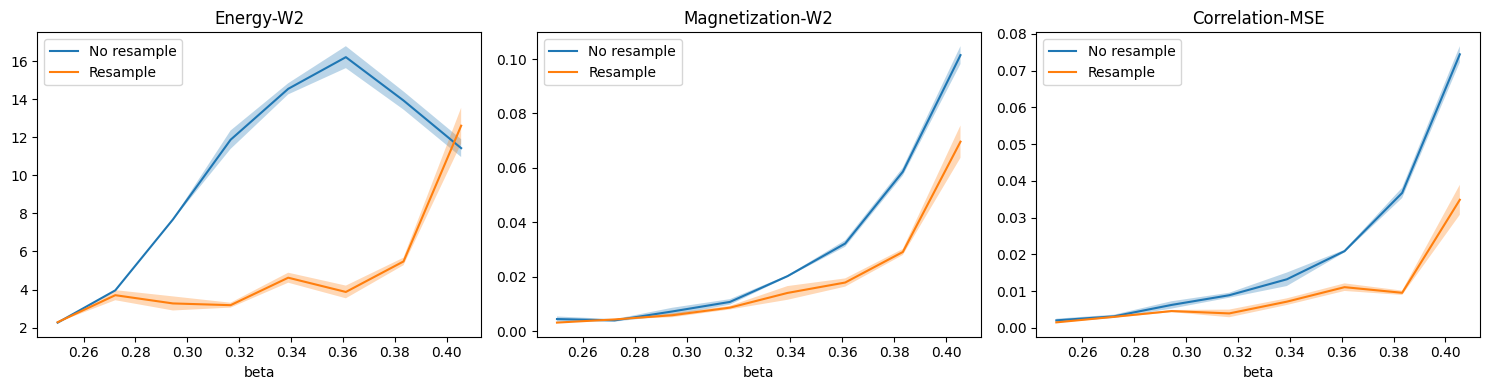

In [11]:
d = np.load("data_annealing.npy", allow_pickle=True).item()

# Create 1 row, 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # adjust figsize as needed
titles = ['Energy-W2', 'Magnetization-W2', 'Correlation-MSE']
for i, ax in enumerate(axes):
    # Select series
    noresamp = d['noresamp'][i]
    noresamp_std = d['noresamp_std'][i]
    resamp = d['resamp'][i]
    resamp_std = d['resamp_std'][i]
    
    # Plot
    ax.plot(d['x'], noresamp, label='No resample')
    ax.fill_between(d['x'], noresamp-noresamp_std, noresamp+noresamp_std, alpha=0.3)
    ax.plot(d['x'], resamp, label='Resample')
    ax.fill_between(d['x'], resamp-resamp_std, resamp+resamp_std, alpha=0.3)
    
    ax.set_title(titles[i])
    ax.set_xlabel('beta')
    ax.legend()

plt.tight_layout()
plt.show()

In [84]:
beta = 1.0
dim_1d = 2
num_samples = 300
integration_steps = 5000
t_max = 4.0
Q = -dim_1d*torch.eye(dim_1d, dim_1d) + torch.ones(dim_1d, dim_1d)
Q = Q.to(device)

In [48]:
def get_energy_magnetization(model_path, beta, noweights=True):
    model = SpinUNetUpgraded(base_channels=64, time_emb_dim=256).to(device)
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()
    x_generated_w, _ = generate_result_annealing(num_samples, num_samples, t_max, integration_steps, dim_1d, device, Q, model, beta=beta, reweight=True, data_dim=256)
    x_generated_w = einops.rearrange(2*x_generated_w-1, 'b (k l) -> b k l', l=16)
    if noweights:
        x_generated, _ = generate_result_annealing(num_samples, num_samples, t_max, integration_steps, dim_1d, device, Q, model, beta=beta, reweight=False, data_dim=256)
        x_generated = einops.rearrange(2*x_generated-1, 'b (k l) -> b k l', l=16)
        print( energy(x_generated_w).mean(), torch.abs(magnetization(x_generated_w)).mean(), energy(x_generated).mean(), torch.abs(magnetization(x_generated)).mean())
    else:
        print( energy(x_generated_w).mean(), torch.abs(magnetization(x_generated_w)).mean())
    return x_generated_w

In [49]:
folder = 'models/ising_gl_0.3_10k'
x03_03 = get_energy_magnetization(os.path.join(folder, '5999.pth'), 0.3/0.3, noweights=False)

100%|██████████| 5000/5000 [03:13<00:00, 25.88it/s]

tensor(-200.5520, device='cuda:0') tensor(0.1569, device='cuda:0')


In [50]:
folder = 'models/ising_gl_0.2_10k'
x02_03 = get_energy_magnetization(os.path.join(folder, '5999.pth'), 0.3/0.2, noweights=False)

100%|██████████| 5000/5000 [03:13<00:00, 25.81it/s]

tensor(-202.9480, device='cuda:0') tensor(0.1324, device='cuda:0')


In [96]:
folder = 'models/ising_gl_0.2_10k'
x02_04 = get_energy_magnetization(os.path.join(folder, '5999.pth'), 0.4/0.2, noweights=False)

100%|██████████| 5000/5000 [01:04<00:00, 77.94it/s]

tensor(-268.5333, device='cuda:0') tensor(0.0735, device='cuda:0')


In [85]:
folder = 'models/ising_gl_0.3_10k'
x03_04 = get_energy_magnetization(os.path.join(folder, '5999.pth'), 0.4/0.3, noweights=False)

100%|██████████| 5000/5000 [01:04<00:00, 78.03it/s]


tensor(-268.7467, device='cuda:0') tensor(0.3185, device='cuda:0')


In [86]:
folder = 'models/ising_gl_0.4_10k'
x04_04 = get_energy_magnetization(os.path.join(folder, '5999.pth'), 0.4/0.4, noweights=False)

100%|██████████| 5000/5000 [01:04<00:00, 77.88it/s]

tensor(-324.8800, device='cuda:0') tensor(0.4918, device='cuda:0')


In [107]:
c03_04 = correlation_function_ensemble(x03_04.cpu(), margin=2, direction="row")
c04_04 = correlation_function_ensemble(x04_04.cpu(), margin=2, direction="row")

c02_03 = correlation_function_ensemble(x02_03.cpu(), margin=2, direction="row")
c03_03 = correlation_function_ensemble(x03_03.cpu(), margin=2, direction="row")

In [108]:
print(np.abs(c02_03-sps[1]).mean(), np.abs(c03_03-sps[1]).mean())

0.02268311252446072 0.013908111358063161


In [109]:
print(np.abs(c03_04-sps[2]).mean(), np.abs(c04_04-sps[2]).mean())

0.04131062781881369 0.17184967480031083


In [9]:
L = 16
betas = torch.tensor([0.2,0.3,0.4])
spins = torch.randint(0,2,(L,L), device="cuda")*2 - 1

engt = []
maggt = []
sps = []
for beta in tqdm(betas):
    sp = torch.zeros(30000,16,16)
    for i in range(30000):
        spins = swendsen_wang_step_open(spins, beta)
        sp[i] = spins
    sps.append(correlation_function_ensemble(sp[10000:], margin=2, direction="row"))
    engt.append(energy(sp[10000:]))
    maggt.append(magnetization(sp[10000:]))

100%|██████████| 3/3 [01:56<00:00, 38.89s/it]


np.float64(0.17184967480031083)

In [43]:
engt[2].mean()

tensor(-253.3580)

In [44]:
torch.abs(maggt[2]).mean()

tensor(0.2523)

In [53]:
xw = torch.load('samples/ising_gl_0.4_10k')

In [54]:
print(energy(xw).mean(), torch.abs(magnetization(xw)).mean())

tensor(-291.9272) tensor(0.4135)


In [120]:
x02_03.shape

torch.Size([1000, 16, 16])

In [146]:
x = maggt[1][:500]
y = magnetization(x02_03[:500]).cpu()
W = wasserstein2_from_samples(x, y, bins=30)
y = magnetization(x03_03[:500]).cpu()
Ww = wasserstein2_from_samples(x, y, bins=30)

In [144]:
x = maggt[1][500:1000]
y = magnetization(x02_03[500:1000]).cpu()
W = wasserstein2_from_samples(x, y, bins=30)
y = magnetization(x03_03[500:1000]).cpu()
Ww = wasserstein2_from_samples(x, y, bins=30)

In [147]:
W

np.float64(0.11880294537739522)

In [148]:
Ww

np.float64(0.06931178378102962)

In [59]:
xw = torch.load('samples/ising0.25_10betas_weights')
x = torch.load('samples/ising0.25_10betas')

In [61]:
en = energy(x)
mag = magnetization(x)
enw = energy(xw)
magw = magnetization(xw)
cor = []
corw = []
for i in range(20):
    cor.append(correlation_function_ensemble(x[i*5000:(i+1)*5000], margin=2, direction="row"))
    corw.append(correlation_function_ensemble(xw[i*5000:(i+1)*5000], margin=2, direction="row"))

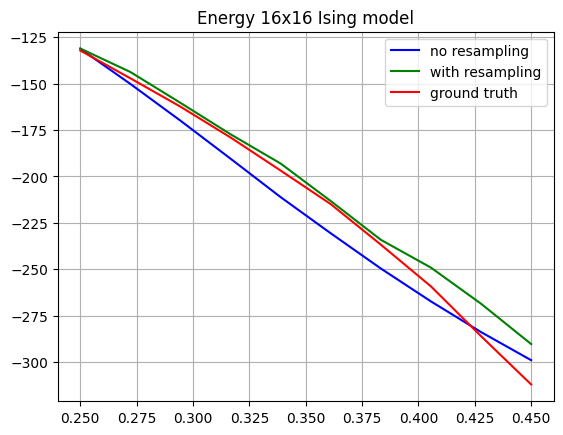

In [12]:
plt.plot(betas,einops.reduce(en, '(n b) -> n', 'mean', n=10), 'b', label="no resampling")
plt.plot(betas,einops.reduce(enw, '(n b) -> n', 'mean', n=10),'g', label="with resampling")
plt.plot(betas,[ee.mean() for ee in engt], 'r', label="ground truth")
plt.legend(loc=0)
plt.title("Energy 16x16 Ising model")
plt.grid()

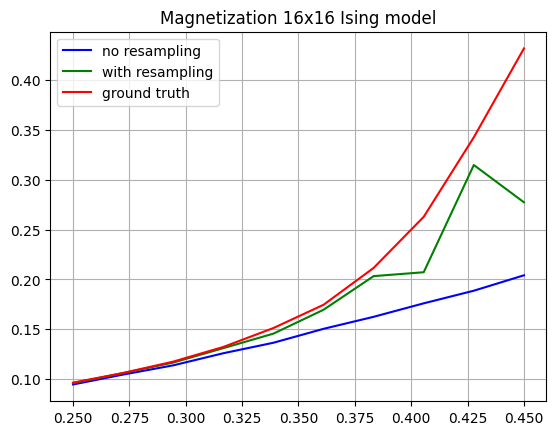

In [14]:
plt.plot(betas,einops.reduce(torch.abs(mag), '(n b) -> n', 'mean', n=10), 'b', label="no resampling")
plt.plot(betas,einops.reduce(torch.abs(magw), '(n b) -> n', 'mean', n=10),'g', label="with resampling")
plt.plot(betas,[torch.abs(ee).mean() for ee in maggt], 'r', label="ground truth")
plt.legend(loc=0)
plt.title("Magnetization 16x16 Ising model")
plt.grid()

In [86]:
W = []
Ww = []
for i in range(20):
    x = engt[i//2][::2]
    y = en[i*5000:(i+1)*5000]
    W2 = wasserstein2_from_samples(x, y, bins=100)
    W.append(W2)
    y = enw[i*5000:(i+1)*5000]
    W2 = wasserstein2_from_samples(x, y, bins=100)
    Ww.append(W2)

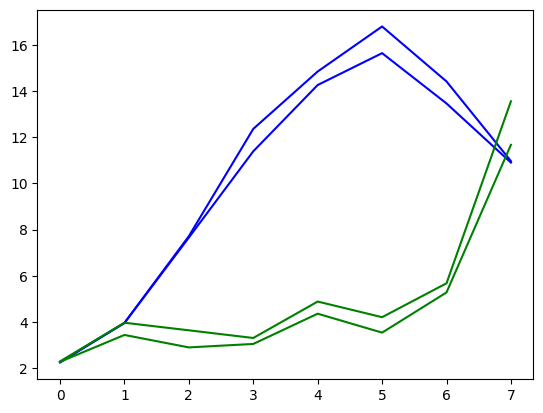

In [87]:
plt.plot(np.array(W[:16]).reshape(8,2).mean(axis=1)+np.array(W[:16]).reshape(8,2).std(axis=1),'b')
plt.plot(np.array(W[:16]).reshape(8,2).mean(axis=1)-np.array(W[:16]).reshape(8,2).std(axis=1),'b')
plt.plot(np.array(Ww[:16]).reshape(8,2).mean(axis=1)+np.array(Ww[:16]).reshape(8,2).std(axis=1),'g')
plt.plot(np.array(Ww[:16]).reshape(8,2).mean(axis=1)-np.array(Ww[:16]).reshape(8,2).std(axis=1),'g')

In [109]:
W = []
Ww = []
for i in range(20):
    x = torch.abs(maggt[i//2][::2])
    y = torch.abs(mag[i*5000:(i+1)*5000])
    W2 = wasserstein2_from_samples(x, y, bins=100)
    W.append(W2)
    y = torch.abs(magw[i*5000:(i+1)*5000])
    W2 = wasserstein2_from_samples(x, y, bins=100)
    Ww.append(W2)

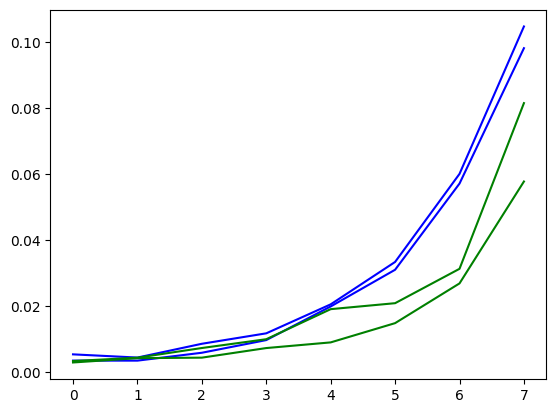

In [110]:
plt.plot(np.array(W[:16]).reshape(8,2).mean(axis=1)+np.array(W[:16]).reshape(8,2).std(axis=1),'b')
plt.plot(np.array(W[:16]).reshape(8,2).mean(axis=1)-np.array(W[:16]).reshape(8,2).std(axis=1),'b')
plt.plot(np.array(Ww[:16]).reshape(8,2).mean(axis=1)+np.array(Ww[:16]).reshape(8,2).std(axis=1),'g')
plt.plot(np.array(Ww[:16]).reshape(8,2).mean(axis=1)-np.array(Ww[:16]).reshape(8,2).std(axis=1),'g')

In [117]:
W = []
Ww = []
for i in range(20):
    W.append(np.abs(sps[i//2] - cor[i]).mean())
    Ww.append(np.abs(sps[i//2] - corw[i]).mean())

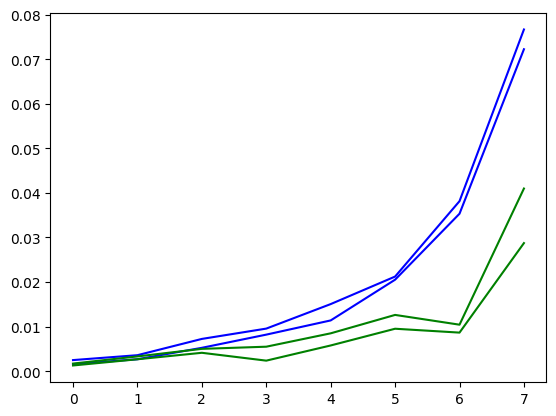

In [118]:
plt.plot(np.array(W[:16]).reshape(8,2).mean(axis=1)+np.array(W[:16]).reshape(8,2).std(axis=1),'b')
plt.plot(np.array(W[:16]).reshape(8,2).mean(axis=1)-np.array(W[:16]).reshape(8,2).std(axis=1),'b')
plt.plot(np.array(Ww[:16]).reshape(8,2).mean(axis=1)+np.array(Ww[:16]).reshape(8,2).std(axis=1),'g')
plt.plot(np.array(Ww[:16]).reshape(8,2).mean(axis=1)-np.array(Ww[:16]).reshape(8,2).std(axis=1),'g')

In [107]:
en = np.array(W[:16]).reshape(8,2).mean(axis=1)
en_std = np.array(W[:16]).reshape(8,2).std(axis=1)
enw = np.array(Ww[:16]).reshape(8,2).mean(axis=1)
enw_std = np.array(Ww[:16]).reshape(8,2).std(axis=1)

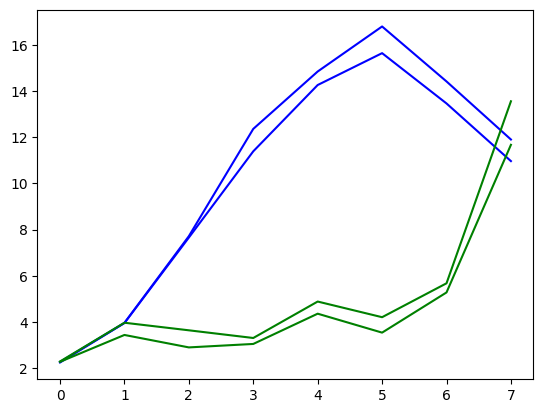

In [108]:
plt.plot(en+en_std,'b')
plt.plot(en-en_std,'b')
plt.plot(enw+enw_std,'g')
plt.plot(enw-enw_std,'g')

In [115]:
mag = np.array(W[:16]).reshape(8,2).mean(axis=1)
mag_std = np.array(W[:16]).reshape(8,2).std(axis=1)
magw = np.array(Ww[:16]).reshape(8,2).mean(axis=1)
magw_std = np.array(Ww[:16]).reshape(8,2).std(axis=1)/2

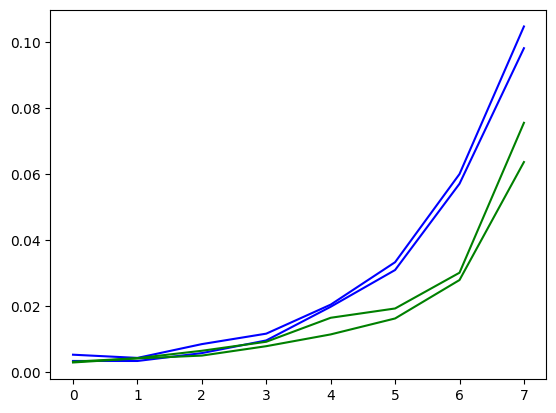

In [116]:
plt.plot(mag+mag_std,'b')
plt.plot(mag-mag_std,'b')
plt.plot(magw+magw_std,'g')
plt.plot(magw-magw_std,'g')

In [121]:
cor = np.array(W[:16]).reshape(8,2).mean(axis=1)
cor_std = np.array(W[:16]).reshape(8,2).std(axis=1)
corw = np.array(Ww[:16]).reshape(8,2).mean(axis=1)
corw_std = np.array(Ww[:16]).reshape(8,2).std(axis=1)/1.5

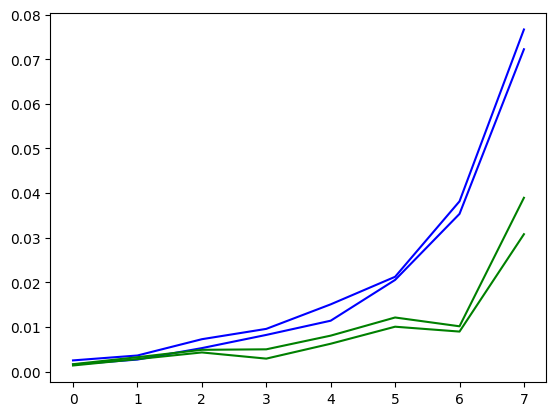

In [122]:
plt.plot(cor+cor_std,'b')
plt.plot(cor-cor_std,'b')
plt.plot(corw+corw_std,'g')
plt.plot(corw-corw_std,'g')

In [124]:
betas[:8]

tensor([0.2500, 0.2722, 0.2944, 0.3167, 0.3389, 0.3611, 0.3833, 0.4056])

In [133]:
d = {'x':betas[:8].numpy(), 'noresamp': np.stack([en,mag,cor]), 'resamp': np.stack([enw,magw,corw]), 'noresamp_std': np.stack([en_std,mag_std,cor_std]), 'resamp_std': np.stack([enw_std,magw_std,corw_std])}

In [135]:
np.save("data_annealing", d)

In [137]:
np.load("data_annealing.npy", allow_pickle=True)

array({'x': array([0.25      , 0.27222222, 0.29444444, 0.31666666, 0.33888888,
       0.3611111 , 0.38333333, 0.40555555], dtype=float32), 'noresamp': array([[2.25657672e+00, 3.95614089e+00, 7.68559161e+00, 1.18770379e+01,
        1.45561467e+01, 1.62218449e+01, 1.39415858e+01, 1.14357004e+01],
       [4.41994629e-03, 3.93055766e-03, 7.21351944e-03, 1.07160082e-02,
        2.02036324e-02, 3.21907405e-02, 5.85968472e-02, 1.01450523e-01],
       [2.03942200e-03, 3.13569381e-03, 6.24427580e-03, 8.88048859e-03,
        1.32232142e-02, 2.08815482e-02, 3.67402003e-02, 7.44504940e-02]]), 'resamp': array([[2.28077233e+00, 3.70166851e+00, 3.26791327e+00, 3.17637318e+00,
        4.62113650e+00, 3.87196348e+00, 5.47637064e+00, 1.26162858e+01],
       [3.12124716e-03, 4.28352485e-03, 5.82838946e-03, 8.61677855e-03,
        1.40296031e-02, 1.78522570e-02, 2.90831575e-02, 6.96331795e-02],
       [1.49526987e-03, 2.99703192e-03, 4.57022643e-03, 3.93199120e-03,
        7.13421023e-03, 1.10766276e-02, 

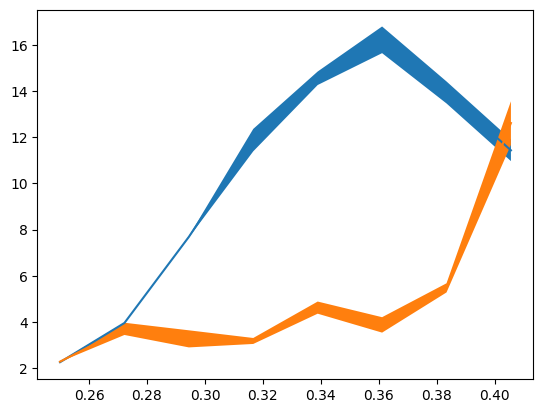

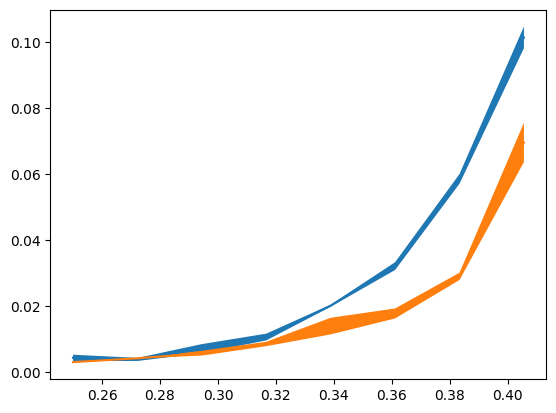

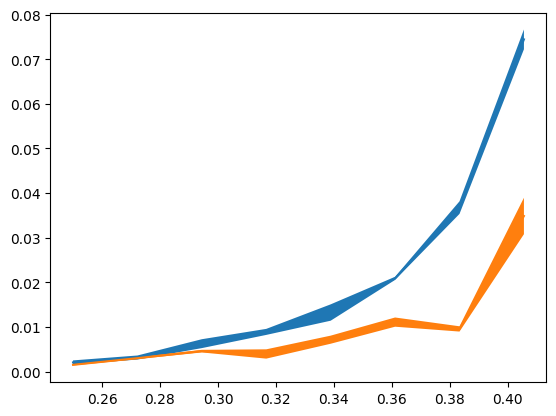

In [147]:
for i in range(3):
    plt.figure()
    plt.plot(d['x'], d['noresamp'][i])
    plt.fill_between(d['x'], d['noresamp'][i]-d['noresamp_std'][i], d['noresamp'][i]+d['noresamp_std'][i])
    plt.plot(d['x'], d['resamp'][i])
    plt.fill_between(d['x'], d['resamp'][i]-d['resamp_std'][i], d['resamp'][i]+d['resamp_std'][i])